In [ ]:
# ===== GOOGLE COLAB SETUP FOR EXCEL =====
# Cell 1: Install packages và setup
!pip install torch torchvision torchaudio --quiet
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl --quiet

# Check GPU
import torch
print(f"🔥 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🚀 GPU device: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ Running on CPU")

# ===== EXCEL DATA PROCESSOR =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from google.colab import files
import io

class ExcelTelecomProcessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.original_columns = []
        self.feature_columns = []

    def upload_excel_file(self):
        """Upload và đọc file Excel"""
        print("📁 Please upload your Excel file:")
        uploaded = files.upload()

        filename = list(uploaded.keys())[0]
        print(f"✅ File uploaded: {filename}")

        # Read Excel file
        if filename.endswith('.xlsx') or filename.endswith('.xls'):
            df = pd.read_excel(filename)
        else:
            # Fallback to CSV if not Excel
            df = pd.read_csv(filename)

        print(f"📊 Data shape: {df.shape}")
        print(f"📝 Columns: {list(df.columns)}")

        # Display first few rows to understand structure
        print("\n🔍 First 5 rows of data:")
        print(df.head())

        return df

    def auto_detect_columns(self, df):
        """Tự động phát hiện các cột quan trọng"""

        # Các pattern thường gặp trong tên cột telecom
        telecom_patterns = {
            'datetime': ['date', 'time', 'datetime', 'timestamp'],
            'bearer': ['bearer', 'mme'],
            'success_rate': ['sr', 'success', 'rate'],
            'utilization': ['util', 'usage'],
            'throughput': ['throughput', 'speed', 'mbps'],
            'handover': ['handover', 'ho'],
            'user': ['user', 'sau', 'active'],
            'accessibility': ['easr', 'access']
        }

        detected_cols = {}
        datetime_col = None

        # Tìm cột datetime
        for col in df.columns:
            col_lower = str(col).lower()
            for pattern in telecom_patterns['datetime']:
                if pattern in col_lower:
                    datetime_col = col
                    break
            if datetime_col:
                break

        # Auto-select numeric columns (excluding datetime)
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

        # Remove any ID or index columns
        numeric_cols = [col for col in numeric_cols if not any(
            x in str(col).lower() for x in ['id', 'index', 'unnamed']
        )]

        print(f"🎯 Detected datetime column: {datetime_col}")
        print(f"📊 Detected {len(numeric_cols)} numeric columns for analysis")

        return datetime_col, numeric_cols

    def process_excel_data(self, df, datetime_col=None, feature_cols=None):
        """Xử lý dữ liệu Excel thành format phù hợp"""

        df_processed = df.copy()

        # Handle datetime column
        if datetime_col and datetime_col in df.columns:
            try:
                df_processed[datetime_col] = pd.to_datetime(df_processed[datetime_col])
                df_processed = df_processed.set_index(datetime_col)
                print(f"✅ Set {datetime_col} as index")
            except:
                print(f"⚠️ Could not convert {datetime_col} to datetime")

        # If no feature columns specified, use all numeric
        if feature_cols is None:
            feature_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()

        # Clean feature columns
        feature_cols = [col for col in feature_cols if col in df_processed.columns]

        # Handle missing values
        df_processed[feature_cols] = df_processed[feature_cols].fillna(method='ffill').fillna(method='bfill')

        # Remove any infinite values
        df_processed[feature_cols] = df_processed[feature_cols].replace([np.inf, -np.inf], np.nan)
        df_processed = df_processed.dropna()

        # Store column info
        self.original_columns = df.columns.tolist()
        self.feature_columns = feature_cols

        print(f"🧹 Data cleaned. Final shape: {df_processed.shape}")
        print(f"🎯 Using {len(feature_cols)} features: {feature_cols[:5]}{'...' if len(feature_cols) > 5 else ''}")

        return df_processed[feature_cols]

    def create_sequences(self, df, seq_length=48, pred_length=12):
        """Tạo sequences cho training"""

        # Normalize data
        feature_data = df.values
        scaled_data = self.scaler.fit_transform(feature_data)

        print(f"📏 Creating sequences with length {seq_length} → {pred_length}")

        X, y = [], []
        for i in range(len(scaled_data) - seq_length - pred_length + 1):
            X.append(scaled_data[i:(i + seq_length)])
            y.append(scaled_data[(i + seq_length):(i + seq_length + pred_length)])

        X, y = np.array(X), np.array(y)
        print(f"✅ Created {len(X)} sequences of shape {X.shape[1:]} → {y.shape[1:]}")

        return X, y

    def analyze_data_quality(self, df):
        """Phân tích chất lượng dữ liệu"""
        print("\n📈 DATA QUALITY ANALYSIS")
        print("=" * 40)

        # Basic stats
        print(f"📊 Shape: {df.shape}")
        print(f"📅 Date range: {df.index.min()} to {df.index.max()}")
        print(f"⏱️ Time frequency: {pd.infer_freq(df.index)}")

        # Missing values
        missing = df.isnull().sum()
        if missing.sum() > 0:
            print(f"⚠️ Missing values found:")
            print(missing[missing > 0])
        else:
            print("✅ No missing values")

        # Statistical summary
        print(f"\n📊 Statistical Summary:")
        print(df.describe())

        # Plot key features
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Data Overview', fontsize=16)

        # Time series plot
        df.iloc[:, :4].plot(ax=axes[0,0], alpha=0.7)
        axes[0,0].set_title('First 4 Features Over Time')
        axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Correlation heatmap
        corr = df.corr()
        sns.heatmap(corr, ax=axes[0,1], cmap='coolwarm', center=0, square=True)
        axes[0,1].set_title('Feature Correlations')

        # Distribution of values
        df.iloc[:, 0].hist(bins=50, ax=axes[1,0], alpha=0.7)
        axes[1,0].set_title(f'Distribution: {df.columns[0]}')

        # Box plot for outliers
        df.iloc[:, :5].boxplot(ax=axes[1,1])
        axes[1,1].set_title('Outlier Detection (First 5 Features)')
        axes[1,1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

# ===== OPTIMIZED INFORMER MODEL =====
class CoLabInformer(nn.Module):
    """Informer model tối ưu cho Colab"""
    def __init__(self, input_dim, d_model=256, n_heads=8, n_layers=4,
                 seq_length=48, pred_length=12, dropout=0.1):
        super(CoLabInformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.seq_length = seq_length
        self.pred_length = pred_length

        # Input embedding
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = self._create_positional_encoding(seq_length, d_model)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Output layers
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Linear(d_model, input_dim * pred_length)
        )

        # Layer norm
        self.layer_norm = nn.LayerNorm(d_model)

    def _create_positional_encoding(self, seq_length, d_model):
        pe = torch.zeros(seq_length, d_model)
        position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Input embedding + positional encoding
        x = self.input_embedding(x)
        x = x + self.positional_encoding[:, :seq_len, :].to(x.device)
        x = self.layer_norm(x)

        # Transformer encoding
        x = self.transformer_encoder(x)

        # Global average pooling
        x = torch.mean(x, dim=1)

        # Output projection
        output = self.output_projection(x)
        output = output.view(batch_size, self.pred_length, self.input_dim)

        return output

# ===== DATASET CLASS =====
class TelecomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ===== TRAINING FUNCTION =====
def train_model_colab(X_train, y_train, X_val, y_val, input_dim,
                     epochs=80, batch_size=32, lr=0.001):
    """Training với early stopping và advanced techniques"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🏋️ Training on: {device}")

    # Data loaders
    train_dataset = TelecomDataset(X_train, y_train)
    val_dataset = TelecomDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                             num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=0, pin_memory=True)

    # Model
    model = CoLabInformer(
        input_dim=input_dim,
        seq_length=X_train.shape[1],
        pred_length=y_train.shape[1],
        d_model=256,
        n_heads=8,
        n_layers=4
    ).to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"🧠 Model parameters: {total_params:,}")

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr*10, epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1
    )

    # Training tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0

    print(f"🚀 Starting training for {epochs} epochs...")

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        # Progress reporting
        if epoch % 10 == 0 or epoch == epochs - 1:
            current_lr = scheduler.get_last_lr()[0]
            print(f'Epoch [{epoch:3d}/{epochs}] | Train: {train_loss:.4f} | '
                  f'Val: {val_loss:.4f} | LR: {current_lr:.6f} | '
                  f'Best: {best_val_loss:.4f}')

        # Early stopping
        if patience_counter >= patience:
            print(f"🛑 Early stopping at epoch {epoch}")
            break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, val_losses

# ===== ANOMALY DETECTION =====
def detect_anomalies_advanced(model, X_test, scaler, threshold_percentile=95):
    """Advanced anomaly detection với multiple metrics"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    reconstruction_errors = []
    predictions = []

    print("🔍 Detecting anomalies...")

    with torch.no_grad():
        for i in range(0, len(X_test), 32):
            batch_X = torch.FloatTensor(X_test[i:i+32]).to(device)
            pred = model(batch_X)
            predictions.extend(pred.cpu().numpy())

            # Reconstruction error (compare prediction with actual next sequence)
            true_next = batch_X[:, -pred.shape[1]:, :]
            mse = torch.mean((true_next - pred) ** 2, dim=(1, 2))
            reconstruction_errors.extend(mse.cpu().numpy())

    # Convert to numpy arrays
    reconstruction_errors = np.array(reconstruction_errors)
    predictions = np.array(predictions)

    # Multiple thresholds for different sensitivity levels
    thresholds = {
        'conservative': np.percentile(reconstruction_errors, 99),
        'moderate': np.percentile(reconstruction_errors, 95),
        'sensitive': np.percentile(reconstruction_errors, 90)
    }

    # Anomaly detection results
    results = {}
    for name, threshold in thresholds.items():
        anomalies = reconstruction_errors > threshold
        results[name] = {
            'anomalies': anomalies,
            'count': np.sum(anomalies),
            'percentage': np.mean(anomalies) * 100,
            'threshold': threshold
        }
        print(f"🎯 {name.capitalize()}: {results[name]['count']} anomalies "
              f"({results[name]['percentage']:.1f}%)")

    return results, reconstruction_errors, predictions

# ===== VISUALIZATION =====
def plot_comprehensive_results(df, results, errors, feature_idx=0):
    """Comprehensive visualization of results"""

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('🔍 Telecom Network Anomaly Detection Results', fontsize=16, fontweight='bold')

    # 1. Feature with anomalies
    feature_name = df.columns[feature_idx] if feature_idx < len(df.columns) else f'Feature_{feature_idx}'

    axes[0,0].plot(df.index[:len(errors)], df.iloc[:len(errors), feature_idx],
                   alpha=0.7, linewidth=1, label=feature_name)

    # Plot different sensitivity levels
    colors = ['red', 'orange', 'yellow']
    for i, (name, result) in enumerate(results.items()):
        anomaly_indices = np.where(result['anomalies'])[0]
        if len(anomaly_indices) > 0:
            axes[0,0].scatter(df.index[anomaly_indices],
                            df.iloc[anomaly_indices, feature_idx],
                            color=colors[i], label=f'{name.capitalize()} ({result["count"]})',
                            s=30, alpha=0.8, edgecolor='black', linewidth=0.5)

    axes[0,0].set_title(f'📊 {feature_name} - Anomaly Detection')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Reconstruction errors
    axes[0,1].plot(range(len(errors)), errors, alpha=0.7, linewidth=1, color='blue')

    for i, (name, result) in enumerate(results.items()):
        axes[0,1].axhline(y=result['threshold'], color=colors[i], linestyle='--',
                         alpha=0.8, label=f'{name.capitalize()} threshold')

    axes[0,1].set_title('📈 Reconstruction Errors')
    axes[0,1].set_ylabel('MSE Error')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Error distribution
    axes[1,0].hist(errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')

    for i, (name, result) in enumerate(results.items()):
        axes[1,0].axvline(x=result['threshold'], color=colors[i], linestyle='--',
                         linewidth=2, label=f'{name.capitalize()}')

    axes[1,0].set_title('📊 Error Distribution')
    axes[1,0].set_xlabel('Reconstruction Error')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 4. Anomaly statistics
    names = list(results.keys())
    counts = [results[name]['count'] for name in names]
    percentages = [results[name]['percentage'] for name in names]

    x_pos = np.arange(len(names))
    bars = axes[1,1].bar(x_pos, counts, color=colors, alpha=0.7, edgecolor='black')

    # Add percentage labels on bars
    for i, (bar, pct) in enumerate(zip(bars, percentages)):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                      f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

    axes[1,1].set_title('📊 Anomaly Detection Summary')
    axes[1,1].set_xlabel('Detection Sensitivity')
    axes[1,1].set_ylabel('Number of Anomalies')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels([name.capitalize() for name in names])
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ===== MAIN EXECUTION FUNCTION =====
def run_excel_experiment():
    """🚀 Chạy experiment hoàn chỉnh với Excel data"""

    print("🎯 TELECOM NETWORK ANOMALY DETECTION")
    print("📊 Excel Data → Informer Model → Anomaly Detection")
    print("=" * 60)

    # Step 1: Load Excel data
    processor = ExcelTelecomProcessor()

    print("\n📁 STEP 1: LOADING EXCEL DATA")
    print("-" * 30)
    raw_df = processor.upload_excel_file()

    # Step 2: Auto-detect columns
    print("\n🔍 STEP 2: ANALYZING DATA STRUCTURE")
    print("-" * 35)
    datetime_col, numeric_cols = processor.auto_detect_columns(raw_df)

    # Step 3: Process data
    print("\n🧹 STEP 3: DATA PREPROCESSING")
    print("-" * 28)
    df = processor.process_excel_data(raw_df, datetime_col, numeric_cols)

    # Step 4: Data quality analysis
    processor.analyze_data_quality(df)

    # Step 5: Create sequences
    print("\n📏 STEP 4: CREATING TRAINING SEQUENCES")
    print("-" * 37)

    # Dynamic sequence length based on data size
    data_size = len(df)
    if data_size > 5000:
        seq_length, pred_length = 96, 24
    elif data_size > 2000:
        seq_length, pred_length = 48, 12
    else:
        seq_length, pred_length = 24, 6

    print(f"📊 Data size: {data_size}, Using seq_length: {seq_length}, pred_length: {pred_length}")

    X, y = processor.create_sequences(df, seq_length, pred_length)

    # Step 6: Split data
    print("\n🔄 STEP 5: SPLITTING DATA")
    print("-" * 22)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print(f"✅ Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")

    # Step 7: Train model
    print("\n🏋️ STEP 6: TRAINING INFORMER MODEL")
    print("-" * 33)

    model, train_losses, val_losses = train_model_colab(
        X_train, y_train, X_val, y_val,
        input_dim=len(processor.feature_columns),
        epochs=80,
        batch_size=min(32, len(X_train)//10)
    )

    # Step 8: Plot training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', alpha=0.8)
    plt.plot(val_losses, label='Validation Loss', alpha=0.8)
    plt.title('🏋️ Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    plt.subplot(1, 2, 2)
    plt.plot(train_losses[-20:], label='Train Loss (Last 20)', alpha=0.8)
    plt.plot(val_losses[-20:], label='Val Loss (Last 20)', alpha=0.8)
    plt.title('🎯 Final Training Phase')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Step 9: Anomaly detection
    print("\n🔍 STEP 7: ANOMALY DETECTION")
    print("-" * 26)

    results, errors, predictions = detect_anomalies_advanced(
        model, X_test, processor.scaler
    )

    # Step 10: Comprehensive visualization
    print("\n📊 STEP 8: VISUALIZATION")
    print("-" * 21)

    plot_comprehensive_results(df, results, errors, feature_idx=0)

    # Step 11: Summary report
    print("\n📋 EXPERIMENT SUMMARY")
    print("=" * 25)
    print(f"✅ Data processed: {df.shape[0]} samples, {df.shape[1]} features")
    print(f"🧠 Model trained: {len(train_losses)} epochs")
    print(f"🎯 Final validation loss: {val_losses[-1]:.4f}")
    print(f"🔍 Anomalies detected:")
    for name, result in results.items():
        print(f"   • {name.capitalize()}: {result['count']} ({result['percentage']:.1f}%)")

    # Tạo DataFrame với kết quả
    anomaly_results = pd.DataFrame({
        'timestamp': df.index[:len(errors)],
        'reconstruction_error': errors,
        'is_anomaly_conservative': results['conservative']['anomalies'],
        'is_anomaly_moderate': results['moderate']['anomalies'],
        'is_anomaly_sensitive': results['sensitive']['anomalies']
    })

    # Thêm original features
    for i, col in enumerate(processor.feature_columns):
        anomaly_results[f'original_{col}'] = df.iloc[:len(errors), i].values

    # Save to Excel
    anomaly_results.to_excel('anomaly_detection_results.xlsx', index=False)
    files.download('anomaly_detection_results.xlsx')

    # Tạo summary report
    report = f"""
    TELECOM NETWORK ANOMALY DETECTION REPORT
    ========================================

    Data Overview:
    - Total samples: {len(df):,}
    - Features analyzed: {len(processor.feature_columns)}
    - Time period: {df.index.min()} to {df.index.max()}

    Model Performance:
    - Training epochs: {len(train_losses)}
    - Final validation loss: {val_losses[-1]:.4f}
    - Model parameters: {sum(p.numel() for p in model.parameters()):,}

    Anomaly Detection Results:
    - Conservative (99th percentile): {results['conservative']['count']} anomalies ({results['conservative']['percentage']:.1f}%)
    - Moderate (95th percentile): {results['moderate']['count']} anomalies ({results['moderate']['percentage']:.1f}%)
    - Sensitive (90th percentile): {results['sensitive']['count']} anomalies ({results['sensitive']['percentage']:.1f}%)

    Recommendations:
    - Use MODERATE threshold for production monitoring
    - Investigate periods with reconstruction error > {results['moderate']['threshold']:.4f}
    - Consider retraining model monthly with new data
    """

    print(report)

    # Save report
    with open('anomaly_detection_report.txt', 'w') as f:
        f.write(report)
    files.download('anomaly_detection_report.txt')

    # Save model option
    save_model = input("\n💾 Save trained model? (y/n): ").lower() == 'y'
    if save_model:
        torch.save({
            'model_state_dict': model.state_dict(),
            'scaler': processor.scaler,
            'feature_columns': processor.feature_columns,
            'model_config': {
                'input_dim': len(processor.feature_columns),
                'seq_length': seq_length,
                'pred_length': pred_length
            }
        }, 'telecom_anomaly_model.pth')
        files.download('telecom_anomaly_model.pth')
        print("✅ Model saved and downloaded!")

    return model, processor, results, errors, df

# ===== READY TO RUN =====
print("🚀 READY TO RUN ON GOOGLE COLAB!")
print("=" * 35)
print("1. Upload this code to Google Colab")
print("2. Set Runtime → GPU")
print("3. Run: model, processor, results, errors, df = run_excel_experiment()")
print("4. Upload your Excel file when prompted")
print("5. Enjoy the results! 🎉")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
🔥 CUDA available: True
🚀 GPU device: Tesla T4
💾 GPU memory: 15.8 GB
🚀 READY TO RUN ON GOOGLE COLAB!
1. Upload this code to Google Colab
2. Set Runtime → GPU
3. Run: model, processor, results, errors, df

🎯 TELECOM NETWORK ANOMALY DETECTION
📊 Excel Data → Informer Model → Anomaly Detection

📁 STEP 1: LOADING EXCEL DATA
------------------------------
📁 Please upload your Excel file:


Saving data_hl19.csv to data_hl19.csv
✅ File uploaded: data_hl19.csv
📊 Data shape: (15975, 20)
📝 Columns: ['date', 'BEARER_MME_UTIL', 'CREATE_DEDICATED_BEARER_SR', 'CSFB SR', 'DEDICATED_BEARER_MME', 'EASR', 'INTRA_TAU_SR', 'S1_INTRA_HANDOVER_SR', 'S1_PAGGING_SR', 'SAU_4G', 'SAU_UTIL_4G', 'SERVICE_REQUEST_SR', 'SG_LU_SR', 'SMS_PAGGING_SR', 'BEARER_4G', 'PGW BEARER SR', 'PGW_BEARER_UTIL', 'SGW BEARER SR', 'THROUGHPUT_4G', 'THROUGHPUT_UTIL']

🔍 First 5 rows of data:
            date  BEARER_MME_UTIL  CREATE_DEDICATED_BEARER_SR  CSFB SR  \
0  2/1/2025 0:00            15.46                      100.00   100.00   
1  2/1/2025 0:05            15.44                       97.09   100.00   
2  2/1/2025 0:10            15.43                       91.58    99.00   
3  2/1/2025 0:15            15.41                       98.39    98.70   
4  2/1/2025 0:20            15.41                       98.53    99.01   

   DEDICATED_BEARER_MME   EASR  INTRA_TAU_SR  S1_INTRA_HANDOVER_SR  \
0                

/tmp/ipython-input-1-4070760526.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_processed[feature_cols] = df_processed[feature_cols].fillna(method='ffill').fillna(method='bfill')


       BEARER_MME_UTIL  CREATE_DEDICATED_BEARER_SR       CSFB SR  \
count     15975.000000                15975.000000  15975.000000   
mean         17.149589                   98.288494     99.215995   
std           0.656394                    1.275110      1.078753   
min          15.330000                   72.970000     62.200000   
25%          16.660000                   97.860000     98.980000   
50%          17.140000                   98.410000     99.340000   
75%          17.750000                   98.870000     99.720000   
max          18.430000                  103.570000    108.160000   

       DEDICATED_BEARER_MME          EASR  INTRA_TAU_SR  S1_INTRA_HANDOVER_SR  \
count          15975.000000  15975.000000  15975.000000          15975.000000   
mean             324.109797     95.978683     99.939293             88.385164   
std               34.241146      2.827085      0.098072             10.918101   
min              233.000000     22.790000     99.430000        

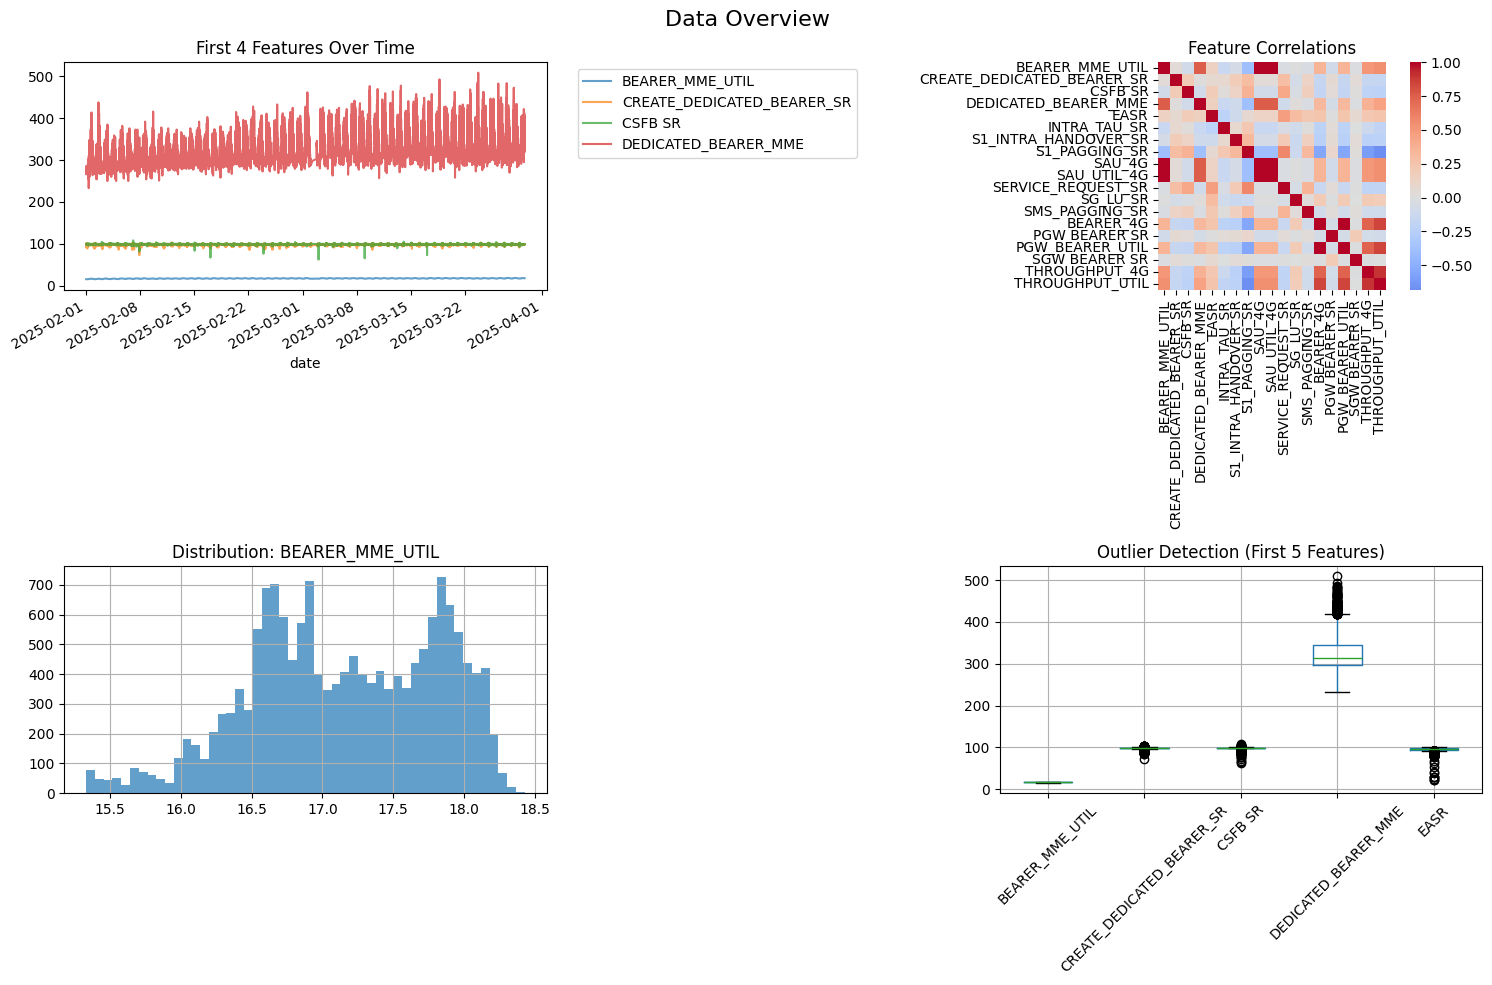


📏 STEP 4: CREATING TRAINING SEQUENCES
-------------------------------------
📊 Data size: 15975, Using seq_length: 96, pred_length: 24
📏 Creating sequences with length 96 → 24
✅ Created 15856 sequences of shape (96, 19) → (24, 19)

🔄 STEP 5: SPLITTING DATA
----------------------
✅ Train: 11099 | Val: 2378 | Test: 2379

🏋️ STEP 6: TRAINING INFORMER MODEL
---------------------------------
🏋️ Training on: cuda
🧠 Model parameters: 3,544,776
🚀 Starting training for 80 epochs...
Epoch [  0/80] | Train: 0.5679 | Val: 0.4332 | LR: 0.000766 | Best: 0.4332
Epoch [ 10/80] | Train: 1.0060 | Val: 0.9311 | LR: 0.009957 | Best: 0.4332
🛑 Early stopping at epoch 15


/tmp/ipython-input-1-4070760526.py:604: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1-4070760526.py:604: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


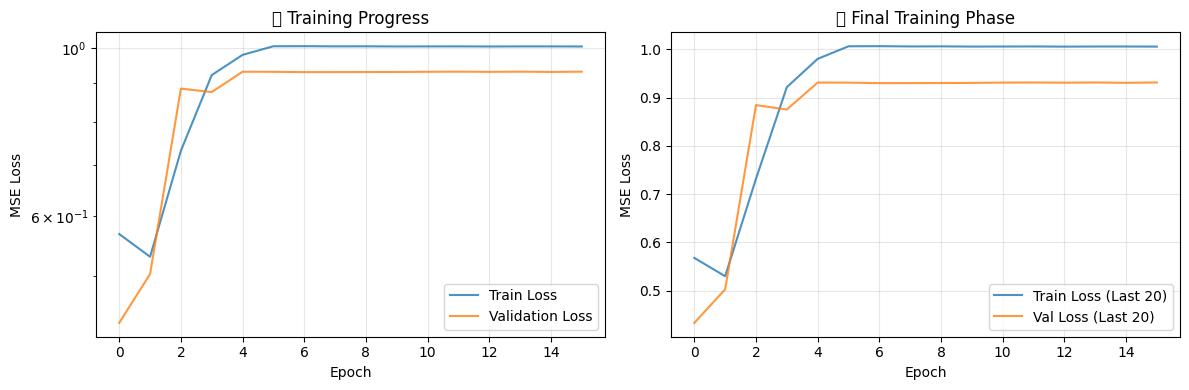


🔍 STEP 7: ANOMALY DETECTION
--------------------------
🔍 Detecting anomalies...
🎯 Conservative: 24 anomalies (1.0%)
🎯 Moderate: 119 anomalies (5.0%)
🎯 Sensitive: 238 anomalies (10.0%)

📊 STEP 8: VISUALIZATION
---------------------


/tmp/ipython-input-1-4070760526.py:516: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1-4070760526.py:516: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1-4070760526.py:516: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) De

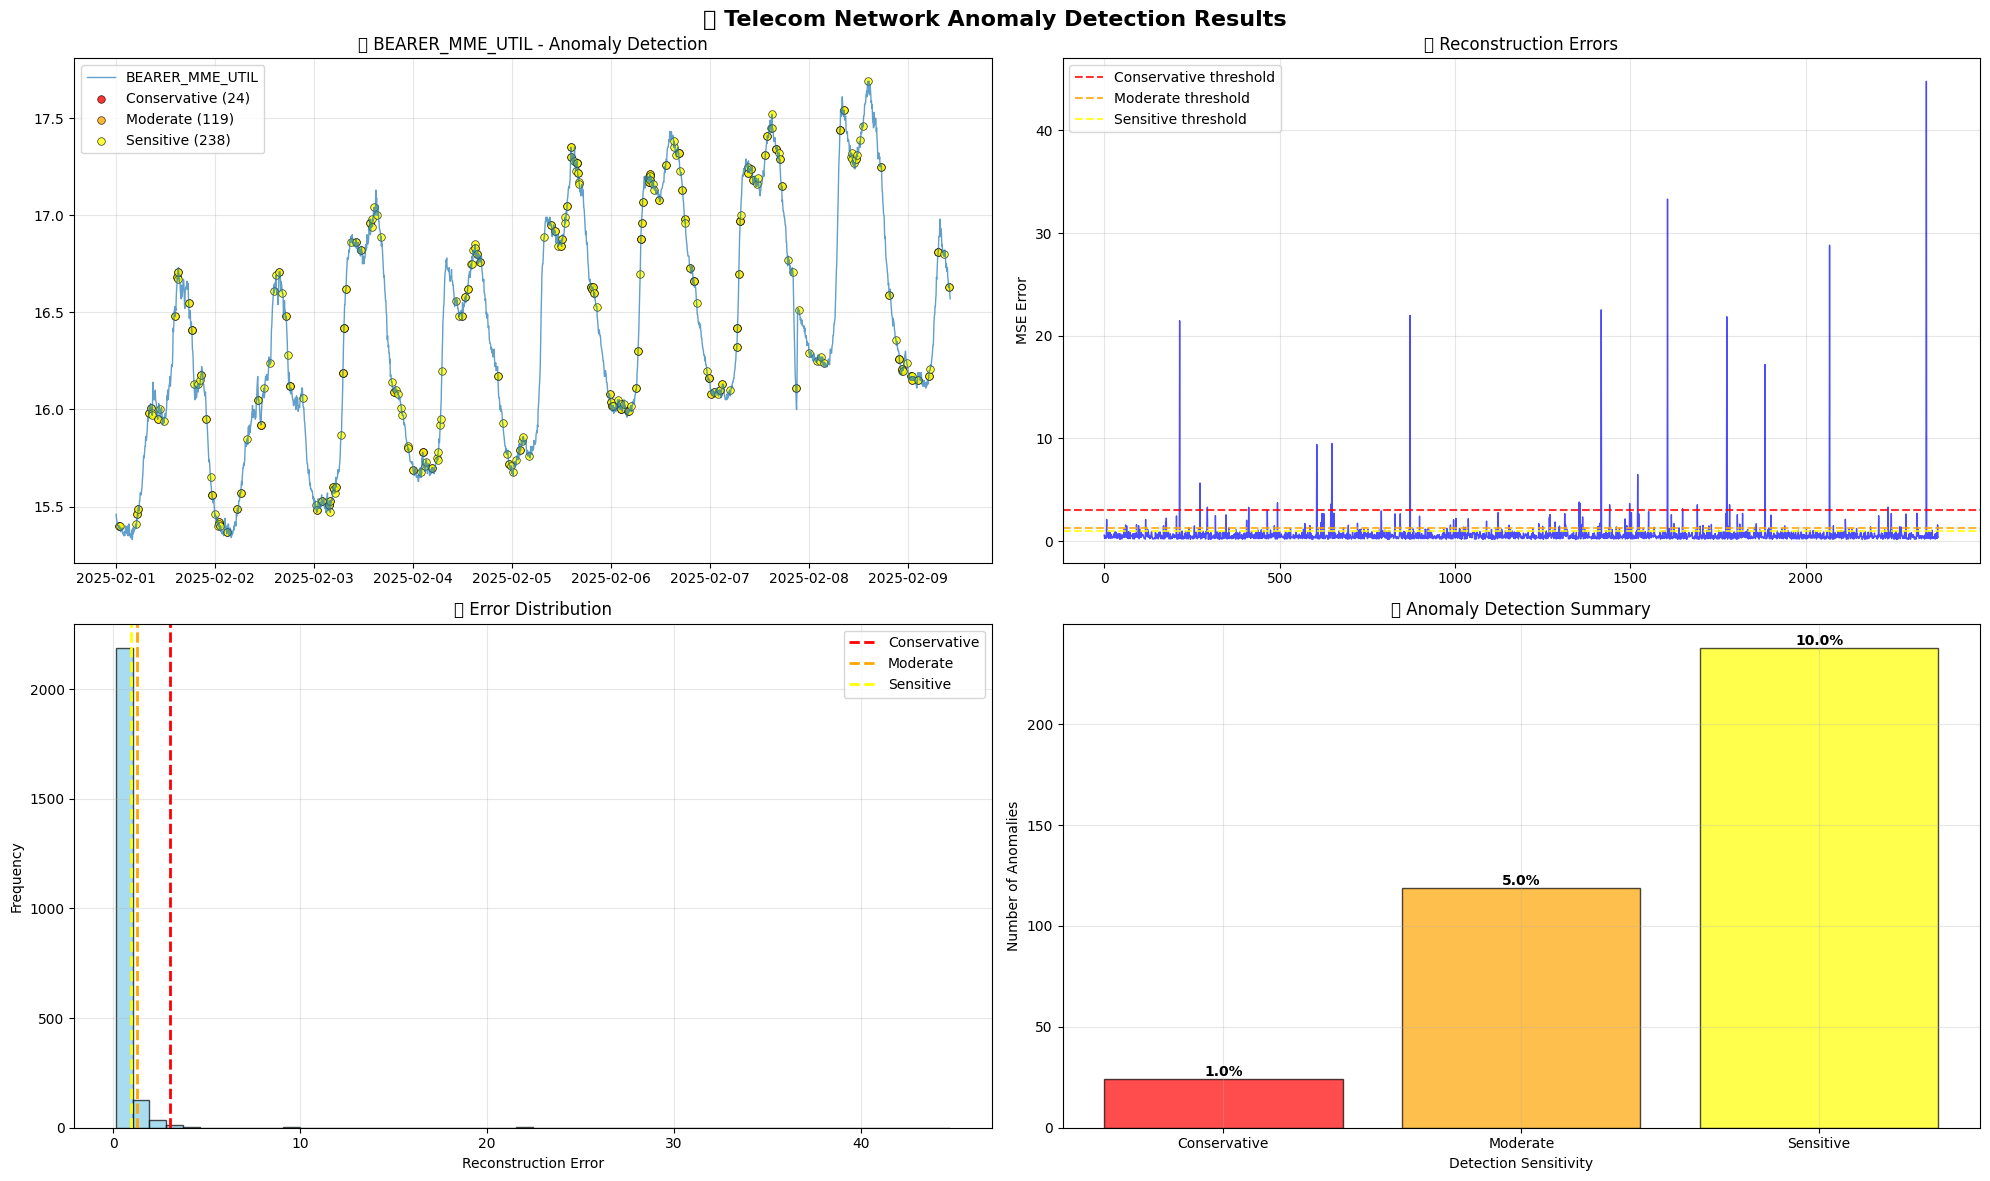


📋 EXPERIMENT SUMMARY
✅ Data processed: 15975 samples, 19 features
🧠 Model trained: 16 epochs
🎯 Final validation loss: 0.9315
🔍 Anomalies detected:
   • Conservative: 24 (1.0%)
   • Moderate: 119 (5.0%)
   • Sensitive: 238 (10.0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


    TELECOM NETWORK ANOMALY DETECTION REPORT

    Data Overview:
    - Total samples: 15,975
    - Features analyzed: 19
    - Time period: 2025-02-01 00:00:00 to 2025-03-29 17:45:00

    Model Performance:
    - Training epochs: 16
    - Final validation loss: 0.9315
    - Model parameters: 3,544,776

    Anomaly Detection Results:
    - Conservative (99th percentile): 24 anomalies (1.0%)
    - Moderate (95th percentile): 119 anomalies (5.0%)
    - Sensitive (90th percentile): 238 anomalies (10.0%)

    Recommendations:
    - Use MODERATE threshold for production monitoring
    - Investigate periods with reconstruction error > 1.2708
    - Consider retraining model monthly with new data
    


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


💾 Save trained model? (y/n): n


In [ ]:
model, processor, results, errors, df = run_excel_experiment()